In [18]:
import pandas as pd
df = pd.read_csv('artefatos/insurance_data_preprocessado.csv')

#Vamos manter apenas as colunas necessárias para o aprendizado não supervisionado, assim vamos dropar as colunas 'cluster' e 'binned_claim'
df.drop(['cluster', 'binned_claim'], axis=1, inplace=True)

In [19]:
df.describe()

,age,imc,bloodpressure,children,claim
count,1148.000000,1148.000000,1148.000000,1148.000000,1148.000000
mean,38.262195,30.012108,91.695122,1.097561,9265.739791
std,11.130050,5.954364,7.769527,1.220671,6211.502024
min,18.000000,16.000000,80.000000,0.000000,1121.870000
25%,29.000000,25.700000,85.000000,0.000000,4350.247500
50%,38.000000,29.700000,91.000000,1.000000,8144.250000
75%,47.000000,33.800000,97.000000,2.000000,12476.440000
max,60.000000,47.500000,118.000000,5.000000,28476.730000


In [20]:
correlacao = df.corr()['claim']
df_correlacao = pd.DataFrame(correlacao)

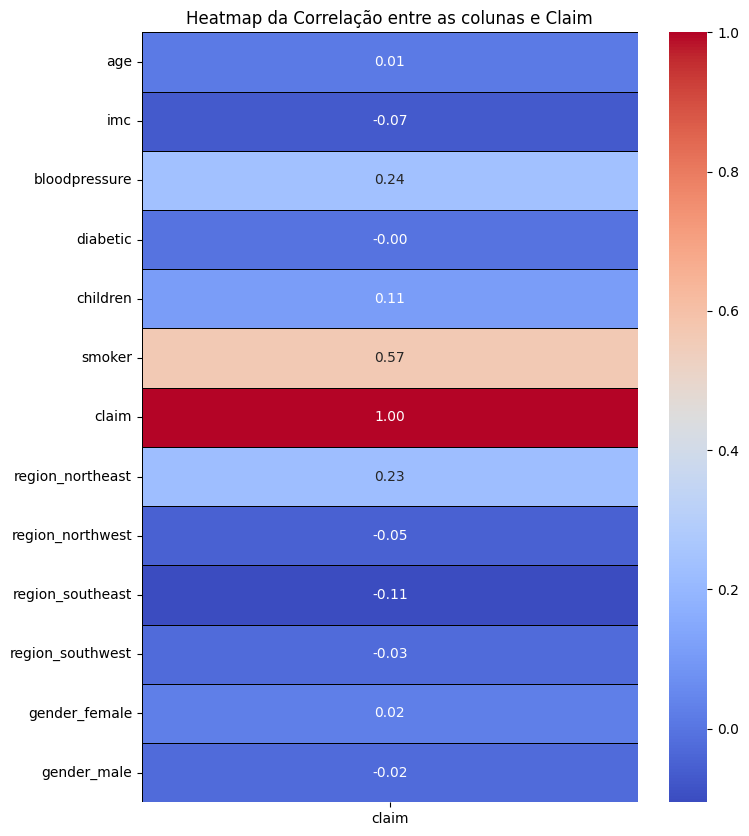

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 10))
sns.heatmap(df_correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Heatmap da Correlação entre as colunas e Claim')
plt.show()

In [22]:

from sklearn.preprocessing import StandardScaler
X = df.drop(['claim'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
df.claim.describe()

count     1148.000000
mean      9265.739791
std       6211.502024
min       1121.870000
25%       4350.247500
50%       8144.250000
75%      12476.440000
max      28476.730000
Name: claim, dtype: float64

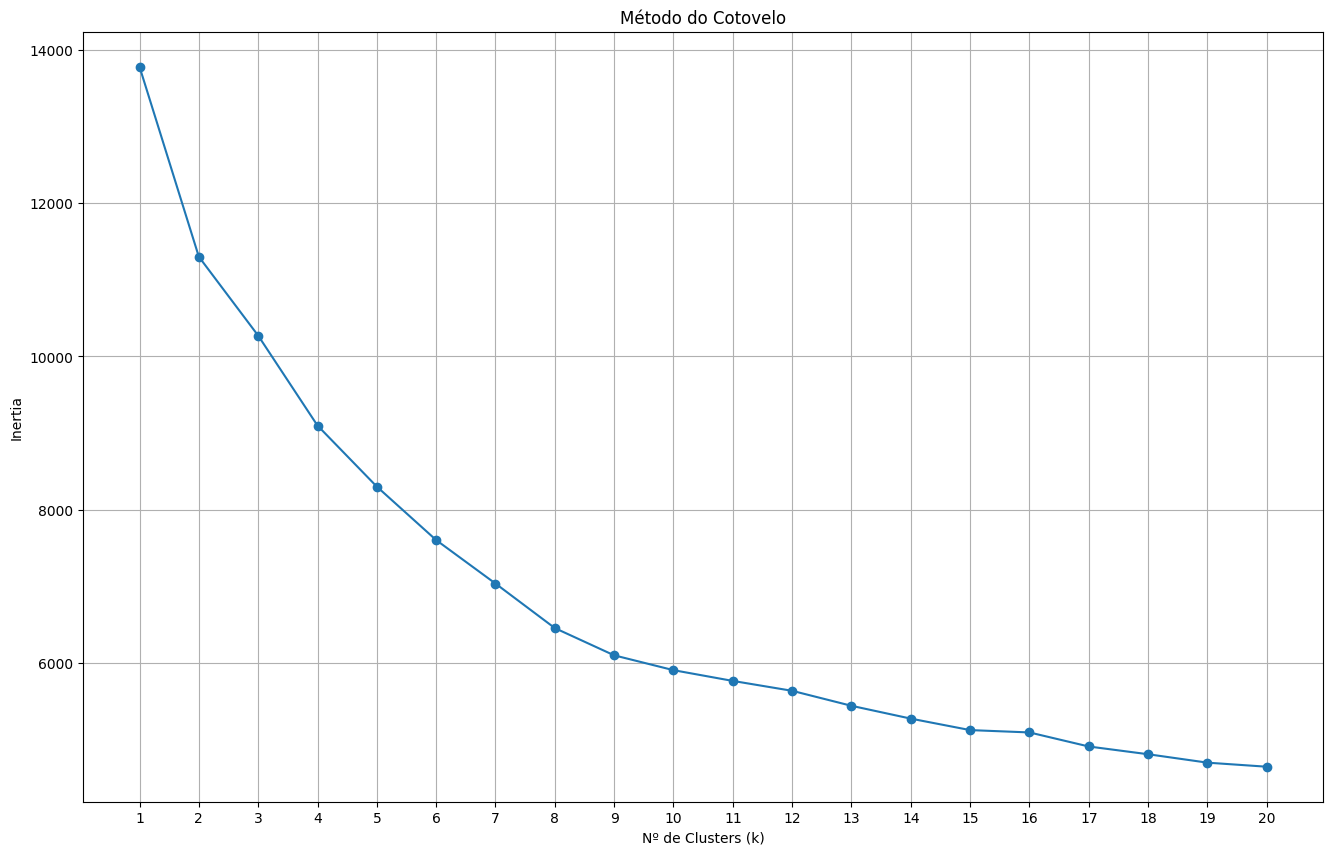

In [24]:
import os
from sklearn.cluster import KMeans
os.environ['LOKY_MAX_CPU_COUNT'] = '-1' # Utiliza a quantidade máxima de processadores.

k_max = 21
inertia_values = []
for k in range(1, k_max):
    kmeans = KMeans(n_clusters=k, random_state=1408, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(16, 10))
plt.plot(range(1, k_max), inertia_values, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Nº de Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, k_max))
plt.grid(True)
plt.show()

## Vamos analisar o tamanho dos Clusters para observar se existe algum tipo de overfitting (clusters com uma quantidade muito pequena de entradas).

In [25]:
for k in range(4, 11):
    print(f"\nContagem de Amostras por Cluster (k={k}):")
    
    kmeans = KMeans(n_clusters=k, random_state=1408, n_init=10)
    df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)
    
    cluster_counts = df['kmeans_cluster'].value_counts().sort_index()
    for cluster, count in cluster_counts.items():
        print(f"  Cluster {cluster}: {count}")

    print('-' * 40)


Contagem de Amostras por Cluster (k=4):
  Cluster 0: 375
  Cluster 1: 276
  Cluster 2: 190
  Cluster 3: 307
----------------------------------------

Contagem de Amostras por Cluster (k=5):
  Cluster 0: 276
  Cluster 1: 201
  Cluster 2: 190
  Cluster 3: 174
  Cluster 4: 307
----------------------------------------

Contagem de Amostras por Cluster (k=6):
  Cluster 0: 253
  Cluster 1: 113
  Cluster 2: 157
  Cluster 3: 160
  Cluster 4: 278
  Cluster 5: 187
----------------------------------------

Contagem de Amostras por Cluster (k=7):
  Cluster 0: 201
  Cluster 1: 161
  Cluster 2: 190
  Cluster 3: 129
  Cluster 4: 147
  Cluster 5: 146
  Cluster 6: 174
----------------------------------------

Contagem de Amostras por Cluster (k=8):
  Cluster 0: 113
  Cluster 1: 146
  Cluster 2: 132
  Cluster 3: 138
  Cluster 4: 160
  Cluster 5: 115
  Cluster 6: 187
  Cluster 7: 157
----------------------------------------

Contagem de Amostras por Cluster (k=9):
  Cluster 0: 113
  Cluster 1: 146
  Clu

In [26]:
best_k = 8

In [27]:
kmeans = KMeans(n_clusters=best_k, random_state=1408, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1408, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)
df['tsne_x'] = X_tsne[:, 0]
df['tsne_y'] = X_tsne[:, 1]

c:\Users\Tales\Python\cienciaDados\unidade3\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


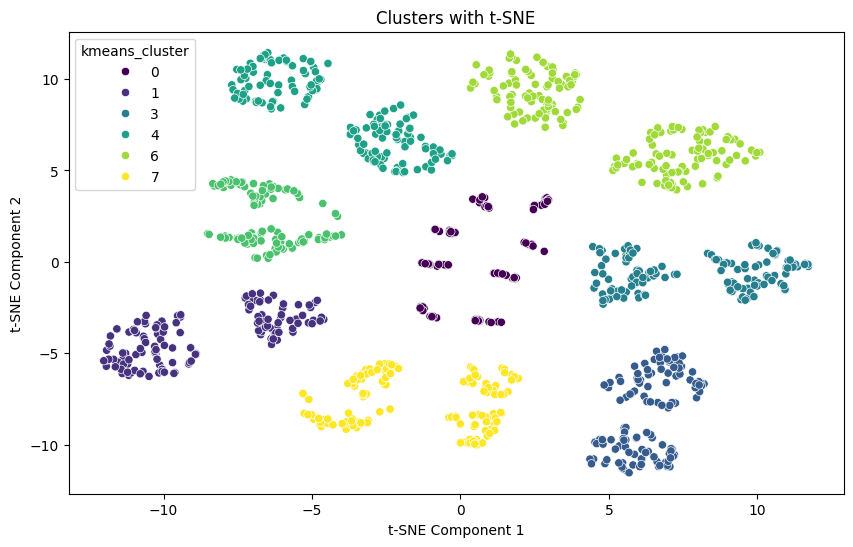

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tsne_x', y='tsne_y', hue='kmeans_cluster', palette='viridis')
plt.title('Clusters with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

C:\Users\Tales\AppData\Local\Temp\ipykernel_9616\1454582927.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='kmeans_cluster', y='claim', palette='viridis')


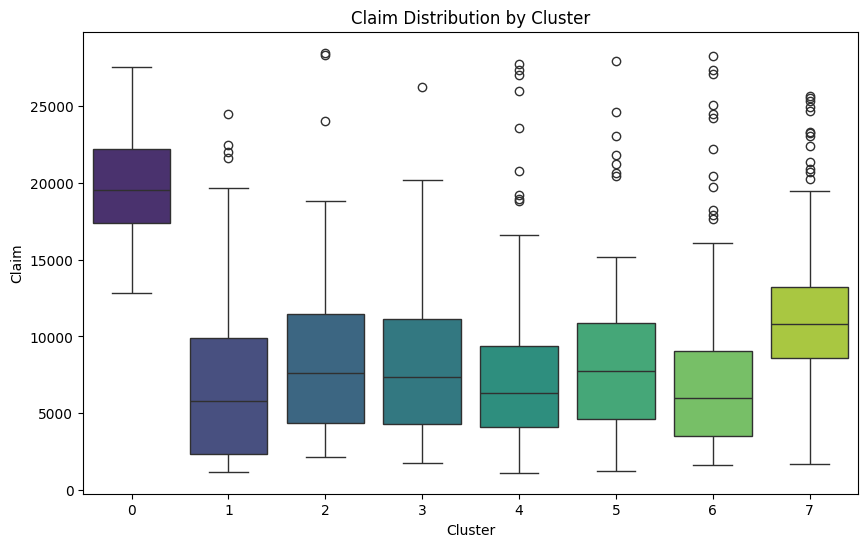

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='kmeans_cluster', y='claim', palette='viridis')
plt.title('Claim Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Claim')
plt.show()

In [31]:
df = df.drop(['tsne_x', 'tsne_y'], axis=1) # Não vamos mais precisar dessas colunas

## Vamos fazer agora a análise do perfil de cada grupo

In [32]:
def calculate_cluster_metrics(df, cluster_column):
    metrics = {}
    for cluster, group in df.groupby(cluster_column):
        metrics[cluster] = {}
        metrics[cluster]['age_median'] = group['age'].median()
        metrics[cluster]['imc_median'] = group['imc'].median()
        metrics[cluster]['bloodpressure_median'] = group['bloodpressure'].median()
        metrics[cluster]['diabetic_percentage'] = group['diabetic'].mean() * 100
        metrics[cluster]['children_mean'] = group['children'].mean()
        metrics[cluster]['smoker_percentage'] = group['smoker'].mean() * 100
        metrics[cluster]['claim_median'] = group['claim'].median()
        metrics[cluster]['region_northeast_percentage'] = group['region_northeast'].mean() * 100
        metrics[cluster]['region_northwest_percentage'] = group['region_northwest'].mean() * 100
        metrics[cluster]['region_southeast_percentage'] = group['region_southeast'].mean() * 100
        metrics[cluster]['region_southwest_percentage'] = group['region_southwest'].mean() * 100
        metrics[cluster]['gender_female_percentage'] = group['gender_female'].mean() * 100
        metrics[cluster]['gender_male_percentage'] = group['gender_male'].mean() * 100
    return metrics

cluster_metrics = calculate_cluster_metrics(df, 'kmeans_cluster')

In [33]:
import numpy as np
df_metrics = pd.DataFrame.from_dict(cluster_metrics, orient='index')
df_metrics.index.name = 'kmeans_cluster'
df_metrics = df_metrics.reset_index()
for column in df_metrics.columns:
    if df_metrics[column].dtype == np.float64:
        df_metrics[column] = df_metrics[column].apply(lambda x: f"{x:.2f}")


df_metrics

,kmeans_cluster,age_median,imc_median,bloodpressure_median,diabetic_percentage,children_mean,smoker_percentage,claim_median,region_northeast_percentage,region_northwest_percentage,region_southeast_percentage,region_southwest_percentage,gender_female_percentage,gender_male_percentage
0,0,38.00,25.40,95.00,52.21,1.18,100.00,19539.24,29.20,25.66,24.78,20.35,48.67,51.33
1,1,33.00,28.85,90.00,43.84,0.91,0.00,5792.45,0.00,100.00,0.00,0.00,0.00,100.00
2,2,42.00,29.60,91.00,44.70,1.17,0.00,7632.20,0.00,100.00,0.00,0.00,100.00,0.00
3,3,41.50,29.65,92.00,47.83,1.13,0.00,7341.41,0.00,0.00,0.00,100.00,100.00,0.00
4,4,35.00,32.85,91.00,47.50,1.25,0.00,6313.91,0.00,0.00,100.00,0.00,0.00,100.00
5,5,33.00,31.00,90.00,44.35,1.22,0.00,7740.34,0.00,0.00,0.00,100.00,0.00,100.00
6,6,43.00,31.10,90.00,51.87,1.01,0.00,5974.38,0.00,0.00,100.00,0.00,100.00,0.00
7,7,39.00,29.60,91.00,49.04,0.99,0.00,10796.35,100.00,0.00,0.00,0.00,50.32,49.68


In [34]:
df_metrics.dtypes

kmeans_cluster                  int64
age_median                     object
imc_median                     object
bloodpressure_median           object
diabetic_percentage            object
children_mean                  object
smoker_percentage              object
claim_median                   object
region_northeast_percentage    object
region_northwest_percentage    object
region_southeast_percentage    object
region_southwest_percentage    object
gender_female_percentage       object
gender_male_percentage         object
dtype: object

In [35]:
df_metrics = df_metrics[df_metrics.iloc[:,1:].columns].astype(float)

In [36]:
cols_to_adjust = [col for col in df_metrics.columns if col.endswith('_percentage')]
df_metrics[cols_to_adjust] = df_metrics[cols_to_adjust] / 100
print(df_metrics)

   age_median  imc_median  bloodpressure_median  diabetic_percentage  \
0        38.0       25.40                  95.0               0.5221   
1        33.0       28.85                  90.0               0.4384   
2        42.0       29.60                  91.0               0.4470   
3        41.5       29.65                  92.0               0.4783   
4        35.0       32.85                  91.0               0.4750   
5        33.0       31.00                  90.0               0.4435   
6        43.0       31.10                  90.0               0.5187   
7        39.0       29.60                  91.0               0.4904   

   children_mean  smoker_percentage  claim_median  \
0           1.18                1.0      19539.24   
1           0.91                0.0       5792.45   
2           1.17                0.0       7632.20   
3           1.13                0.0       7341.41   
4           1.25                0.0       6313.91   
5           1.22                0

In [38]:
df_metrics.to_csv('artefatos/padroesCluster.csv', index=False)